In [10]:
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
from tqdm import *
import matplotlib.pyplot as plt
device = "cuda:0"

In [2]:
train_df = pd.read_csv('../data/train.csv')
valid_df = pd.read_csv('../data/valid.csv')
test_df = pd.read_csv('../data/test.csv')

train_data = torch.tensor(train_df.to_numpy())
valid_data = torch.tensor(valid_df.to_numpy())
test_data = torch.tensor(test_df.to_numpy())

'''获取标签'''
train_y = train_data[:,0]
valid_y = valid_data[:,0]
test_y = test_data[:,0]

'''获取特征'''
train_x = train_data[:, 1:]
valid_x = valid_data[:, 1:]
test_x = test_data[:, 1:]

In [44]:
import numpy as np

X = np.random.rand(20, 20)
crop_size = [5, 3]
X_cropped = random_crop(X, crop_size=crop_size)

ValueError: crop_size is too large for the input matrix

In [58]:
import numpy as np

# 随机选择整列特征进行缩放
def feature_scaling(X):
    num_samples = X.shape[0]
    scaling_factor = np.random.uniform(0.5, 2.0)
    scaling_factors = np.tile(scaling_factor, num_samples)

    return X * scaling_factors

def data_augmentation(X, y, num_samples=1000):
    X_augmented = np.empty((0, X.shape[1]), X.dtype)
    y_augmented = np.empty((0,), y.dtype)
    
    for i in range(num_samples):
        random_idx = np.random.choice(range(len(X)))
        X_sample = X[random_idx]
        y_sample = y[random_idx]
        
        # 增加高斯噪声和随机缩放
        X_sample = add_gaussian_noise(X_sample)
        X_sample = feature_scaling(X_sample)
        
        # 添加增强后的样本
        X_augmented = np.vstack([X_augmented, X_sample])
        y_augmented = np.hstack([y_augmented, y_sample])
        
    return X_augmented, y_augmented

# 增加高斯噪声
def add_gaussian_noise(X, noise_level=0.1):
    return X + np.random.normal(scale=noise_level, size=X.shape)

# 加载数据
X = train_df.iloc[:,1:].values # 提取特征
y = train_df.iloc[:, 0].values # 提取标签
print(X.shape)

# 使用上面定义的函数进行数据增强
X_augmented, y_augmented = data_augmentation(X, y, num_samples=56553)

# 将增强后的数据添加到原始数据中
X_combined = np.vstack([X, X_augmented])
y_combined = np.hstack([y, y_augmented])

print("Combined data shape:", X_combined.shape, y_combined.shape)

(56553, 21)
Combined data shape: (113106, 21) (113106,)


In [59]:
class MLP(nn.Module):
    def __init__(self,input_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2), #几分类问题
        )
    
    def forward(self, x):
        x = self.network(x)
        x = F.softmax(x, dim=1)
        return x

In [60]:
def train(dataloader, model, optimizer, loss_func, epochs, device):
    model = model.to(device)
    model.train()

    losses = []
    for epoch in tqdm(range(epochs)):
        loss = 0 
        for idx, data in enumerate(dataloader):
            x = data[0].to(device).float()
            y = data[1].to(device).long()

            optimizer.zero_grad()
            probs = model(x).float()
            l = loss_func(probs, y)
            l.backward()
            loss+=l.item()
            optimizer.step()
        losses.append(loss)
        
    plt.figure()
    plt.plot(losses)

    return losses[-1]

In [61]:
'''指标计算'''
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def eval(dataloader, model, device):
    model.eval()
    probs = torch.tensor([]).to(device)
    true_labels = torch.tensor([]).to(device)
    with torch.no_grad():
        for idx, data in tqdm(enumerate(dataloader)):
            x = data[0].to(device).float()
            true_labels = torch.cat([true_labels, data[1].to(device)], dim=0)
            prob = model(x).squeeze()
            probs = torch.cat([probs, prob], dim=0)

        # 对多标签问题进行二进制分类处理
        predicted_labels = torch.argmax(probs, dim=1)

        accuracy = balanced_accuracy_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        recall = recall_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')
        precision = precision_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')
        f1 = f1_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')
        auc = roc_auc_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')

        print("模型精度为：{:.4f}".format(accuracy))
        print("模型召回率为：{:.4f}".format(recall))
        print("模型精确率为：{:.4f}".format(precision))
        print("模型F1分数为：{:.4f}".format(f1))
        print("模型AUC值为：{:.4f}".format(auc))

    model.train()

    return predicted_labels

In [72]:
'''准备数据集'''
train_dataset = TensorDataset(torch.tensor(X_combined), torch.tensor(y_combined))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)

valid_dataset = TensorDataset(valid_x, valid_y)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True, drop_last=False)

test_dataset = TensorDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)

In [73]:
loss_fuc = nn.CrossEntropyLoss()
model = MLP(train_x.shape[1], 256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

100%|██████████| 10/10 [00:49<00:00,  4.93s/it]


485.082526832819

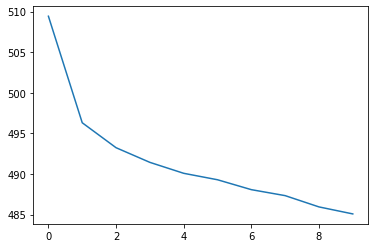

In [74]:
train(train_dataloader, model, optimizer, loss_fuc, 10, device)

In [75]:
print("训练集合指标：")
a=eval(train_dataloader, model, "cuda:0")
print("验证集合指标：")
b=eval(valid_dataloader, model, "cuda:0")
print("测试集合指标：")
c=eval(test_dataloader, model, "cuda:0")

训练集合指标：


884it [00:00, 922.00it/s] 


模型精度为：0.7475
模型召回率为：0.7475
模型精确率为：0.7482
模型F1分数为：0.7473
模型AUC值为：0.7475
验证集合指标：


56it [00:00, 722.91it/s]


模型精度为：0.7331
模型召回率为：0.7331
模型精确率为：0.7342
模型F1分数为：0.7330
模型AUC值为：0.7331
测试集合指标：


56it [00:00, 770.99it/s]

模型精度为：0.7393
模型召回率为：0.7393
模型精确率为：0.7405
模型F1分数为：0.7390
模型AUC值为：0.7393
